In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2 as ps
import pandas.io.sql as sqlio
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = ps.connect(
    dbname="Northwind",
    user="postgres",
    password="Aref870044516",
    host="localhost",
    port= "5432"
)

In [177]:
sql = """
    WITH cte AS (
	SELECT products.product_name, ROUND(SUM(order_details.quantity * order_details.unit_price*(1 - order_details.discount))) AS profit,
	CASE
		WHEN ROUND(SUM(order_details.quantity * order_details.unit_price*(1 - order_details.discount))) >= 15000 THEN 'high_profit'
		WHEN ROUND(SUM(order_details.quantity * order_details.unit_price*(1 - order_details.discount))) BETWEEN 10000 AND 15000 THEN 'average_profit'
		WHEN ROUND(SUM(order_details.quantity * order_details.unit_price*(1 - order_details.discount))) <= 10000 THEN 'low_profit'
		ELSE 'not_segmented'
	END AS profit_segment
FROM orders
LEFT JOIN order_details
ON orders.order_id = order_details.order_id
LEFT JOIN products
ON order_details.product_id = products.product_id
LEFT JOIN categories
ON products.category_id = categories.category_id
GROUP BY products.product_name
	)
	
SELECT product_name, profit, profit_segment,
	COUNT(product_name) OVER (PARTITION BY profit_segment) AS segment_product_count
FROM cte
ORDER BY 4 DESC;
"""

In [178]:
df = sqlio.read_sql_query(sql,conn)
df.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/1600180838.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,product_name,profit,profit_segment,segment_product_count
0,Laughing Lumberjack Lager,2397.0,low_profit,38
1,Aniseed Syrup,3044.0,low_profit,38
2,Röd Kaviar,3997.0,low_profit,38
3,Gravad lax,2688.0,low_profit,38
4,Valkoinen suklaa,3438.0,low_profit,38


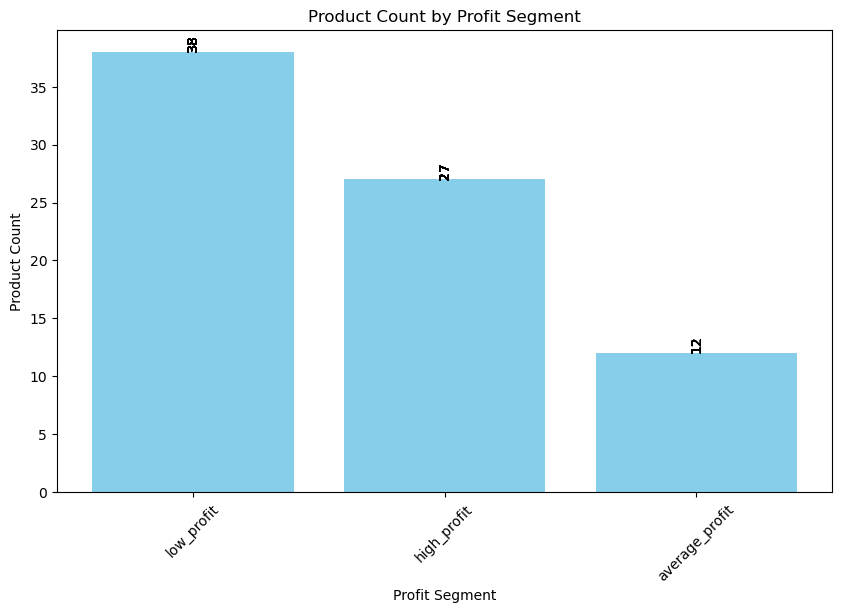

In [179]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df['profit_segment'], df['segment_product_count'], color='skyblue')
plt.xlabel('Profit Segment')
plt.ylabel('Product Count')
plt.title('Product Count by Profit Segment')
plt.xticks(rotation=45)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.show()

In [7]:
sql_2 = """
    WITH freq_mon AS (
	WITH cte_1 AS (
		SELECT customer_id, frequency_rank, monetary_rank,
		DENSE_RANK() OVER (ORDER BY frequency_rank, monetary_rank) AS frequency_monetary_rank
		FROM rfm_table
		ORDER BY frequency_rank, monetary_rank
		)

	SELECT customer_id, frequency_rank, monetary_rank,
		NTILE(3) OVER (ORDER BY frequency_monetary_rank) AS frequency_monetary_ntile
		FROM cte_1),

rec AS (
	SELECT customer_id,
		recency_rank,
		NTILE(3) OVER (ORDER BY recency_rank) AS recency_ntile 
	FROM rfm_table
	)
	
SELECT freq_mon.customer_id, 
	CASE
	WHEN frequency_monetary_ntile = 1 AND recency_ntile = 1 THEN 'champions'
	WHEN frequency_monetary_ntile = 1 AND recency_ntile = 2 THEN 'loyal customers'
	WHEN frequency_monetary_ntile = 1 AND recency_ntile = 3 THEN 'Cant lose them'
	WHEN frequency_monetary_ntile = 2 AND recency_ntile = 1 THEN 'potential loyalist'
	WHEN frequency_monetary_ntile = 2 AND recency_ntile = 2 THEN 'needs attention'
	WHEN frequency_monetary_ntile = 2 AND recency_ntile = 3 THEN 'hibernating'
	WHEN frequency_monetary_ntile = 3 AND recency_ntile = 1 THEN 'price sensitive/promising'
	WHEN frequency_monetary_ntile = 3 AND recency_ntile = 2 THEN 'about to sleep'
	WHEN frequency_monetary_ntile = 3 AND recency_ntile = 3 THEN 'lost'
	END AS predictive_segment	
FROM freq_mon
LEFT JOIN rec
ON freq_mon.customer_id = rec.customer_id
    """

In [195]:
df_2 = sqlio.read_sql_query(sql_2,conn)
df_2.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3477969904.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,customer_id,predictive_segment
0,SAVEA,champions
1,ERNSH,champions
2,QUICK,loyal customers
3,HUNGO,champions
4,FOLKO,champions


In [23]:
import plotly.express as px

segment_counts = df_2['predictive_segment'].value_counts()


segment_counts_df = pd.DataFrame({'segment': segment_counts.index, 'count': segment_counts.values})


total_customers = segment_counts_df['count'].sum()
segment_counts_df['percentage'] = segment_counts_df['count'] / total_customers * 100


fig = px.treemap(segment_counts_df.round(), path=['segment'], values='count', 
                 title='Customer Segmentation', hover_name='segment',
                 color='percentage', color_continuous_scale='rainbow')


for index, row in segment_counts_df.iterrows():
    fig.add_annotation(x=row['segment'], y=0.5, text=f"{row['percentage']:.2f}%", 
                       font=dict(size=14, color='white'), showarrow=False)

fig.update_layout(title_x=0.5, title_y=0.95)
fig.show()

In [26]:
sql3 = """
    SELECT TO_CHAR(order_date, 'MM') AS month_order, TO_CHAR(order_date, 'Month') AS month, 
	COUNT(DISTINCT order_id) AS order_count,
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit
    FROM custom_table
    GROUP BY 1, 2
    ORDER BY 1
"""

In [27]:
df_3 = sqlio.read_sql_query(sql3,conn)
df_3.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3234279600.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,month_order,month,order_count,profit
0,01,January,88,155480.0
1,02,February,83,137899.0
2,03,March,103,143401.0
3,04,April,105,176832.0
4,05,May,46,72115.0


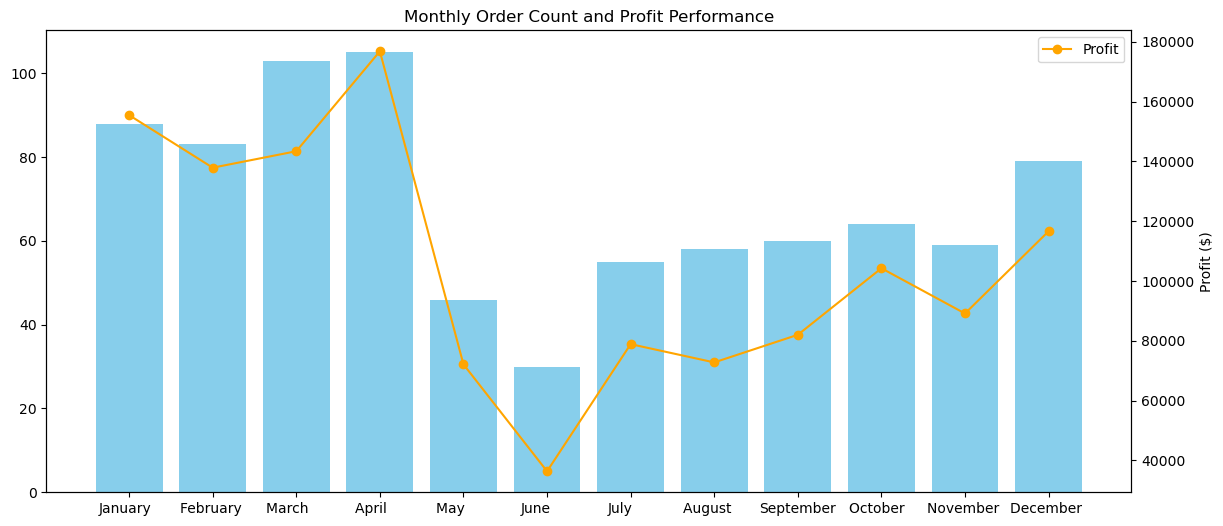

In [30]:
plt.figure(figsize=(14, 6))
plt.bar(df_3['month'], df_3['order_count'], color='skyblue', label='Order Count')


plt.twinx()
plt.plot(df_3['month'], df_3['profit'], color='orange', marker='o', label='Profit')


plt.ylabel('Profit ($)')
plt.title('Monthly Order Count and Profit Performance')
plt.legend()

plt.show()

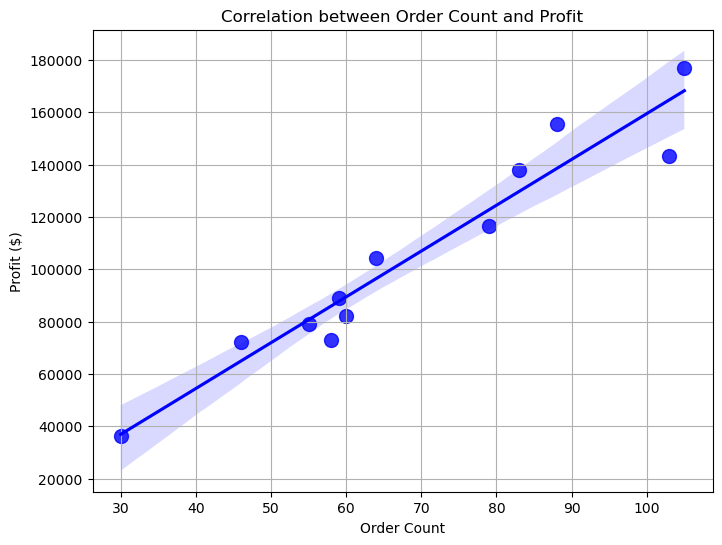

In [33]:
plt.figure(figsize=(8, 6))
sns.regplot(x='order_count', y='profit', data=df_3, color='blue', scatter_kws={'s': 100})
plt.xlabel('Order Count')
plt.ylabel('Profit ($)')
plt.title('Correlation between Order Count and Profit')
plt.grid(True)
plt.show()

In [35]:
sql4 = """
SELECT TO_CHAR(order_date, 'MM') AS month_order, TO_CHAR(order_date, 'Month') AS month, 
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit,
	ROUND(AVG(discount * 100)) AS average_discount
FROM custom_table
GROUP BY 1, 2
ORDER BY 1
"""

In [36]:
df_4 = sqlio.read_sql_query(sql4,conn)
df_4.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3465561040.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,month_order,month,profit,average_discount
0,01,January,155480.0,6.0
1,02,February,137899.0,5.0
2,03,March,143401.0,5.0
3,04,April,176832.0,5.0
4,05,May,72115.0,6.0


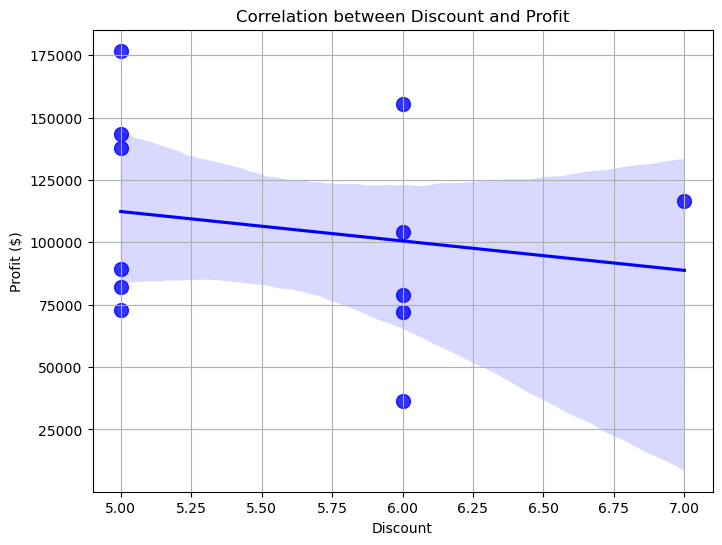

In [196]:
plt.figure(figsize=(8, 6))
sns.regplot(x='average_discount', y='profit', data=df_4, color='blue', scatter_kws={'s': 100})
plt.xlabel('Discount')
plt.ylabel('Profit ($)')
plt.title('Correlation between Discount and Profit')
plt.grid(True)

# Show plot
plt.show()

In [39]:
sql5 = """
SELECT TO_CHAR(order_date, 'MM') AS month_order, TO_CHAR(order_date, 'Month') AS month, 
	COUNT(DISTINCT order_id) AS order_count,
	ROUND(AVG(discount * 100)) AS average_discount
FROM custom_table
GROUP BY 1, 2
ORDER BY 1
"""

In [41]:
df_5 = sqlio.read_sql_query(sql5,conn)
df_5.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/2244818124.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,month_order,month,order_count,average_discount
0,01,January,88,6.0
1,02,February,83,5.0
2,03,March,103,5.0
3,04,April,105,5.0
4,05,May,46,6.0


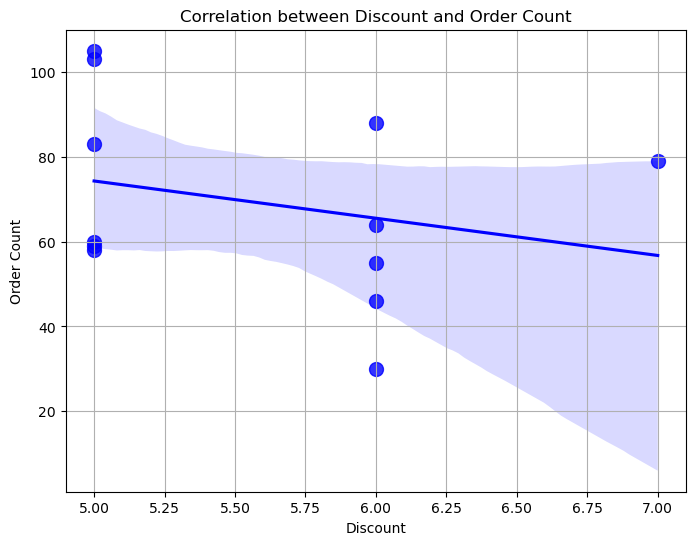

In [198]:
plt.figure(figsize=(8, 6))
sns.regplot(x='average_discount', y='order_count', data=df_5, color='blue', scatter_kws={'s': 100})
plt.xlabel('Discount')
plt.ylabel('Order Count')
plt.title('Correlation between Discount and Order Count')
plt.grid(True)
plt.show()

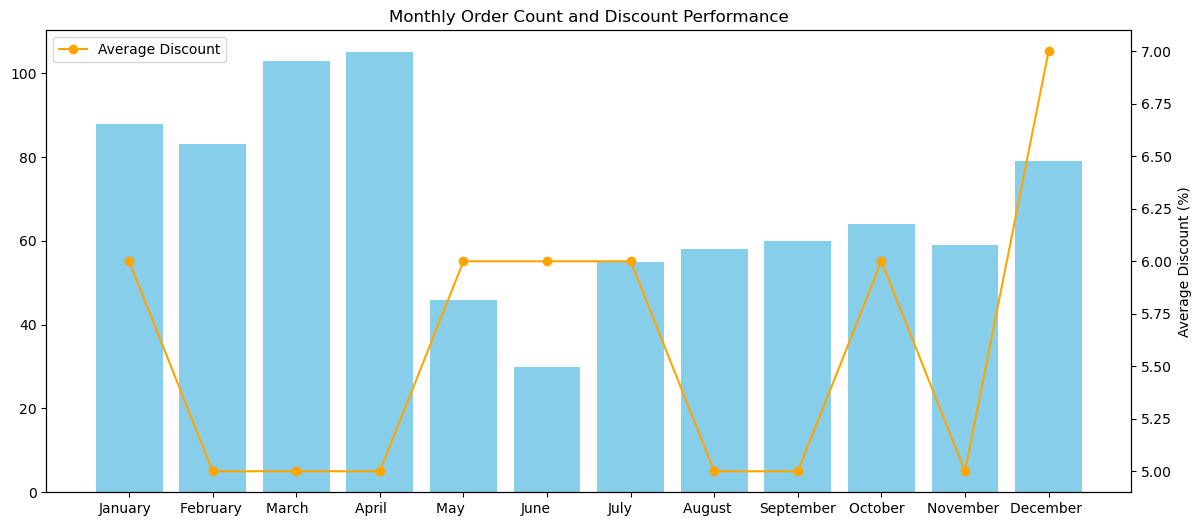

In [45]:
plt.figure(figsize=(14, 6))
plt.bar(df_5['month'], df_5['order_count'], color='skyblue', label='Order Count')


plt.twinx()
plt.plot(df_5['month'], df_5['average_discount'], color='orange', marker='o', label='Average Discount')


plt.ylabel('Average Discount (%)')
plt.title('Monthly Order Count and Discount Performance')
plt.legend()


plt.show()

In [46]:
sql6 = """
SELECT order_id, 
	COUNT(order_id) AS order_count,
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit,
	ROUND(SUM(discount * 100)) AS total_discount
FROM custom_table
GROUP BY 1
"""

In [47]:
df_6 = sqlio.read_sql_query(sql6, conn)
df_6.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/2341158908.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,order_id,order_count,profit,total_discount
0,11038,3,733.0,20.0
1,10782,1,12.0,0.0
2,10725,3,288.0,0.0
3,10423,2,1020.0,0.0
4,10518,3,4150.0,0.0


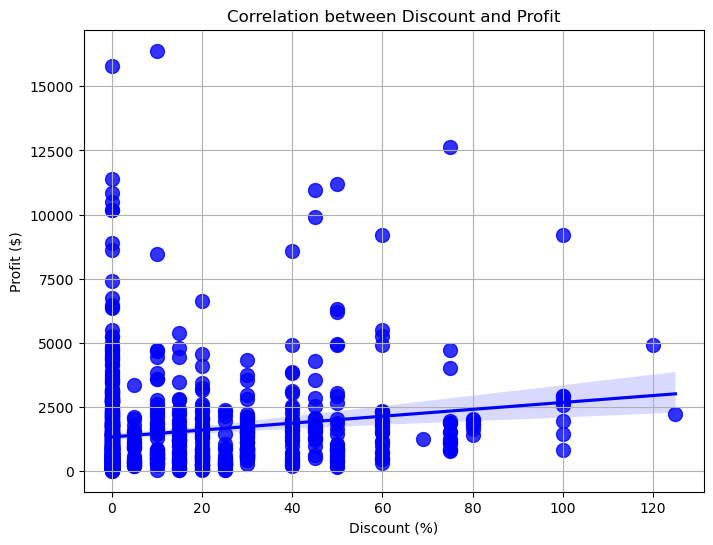

In [48]:
plt.figure(figsize=(8, 6))
sns.regplot(x='total_discount', y='profit', data=df_6, color='blue', scatter_kws={'s': 100})
plt.xlabel('Discount (%)')
plt.ylabel('Profit ($)')
plt.title('Correlation between Discount and Profit')
plt.grid(True)

# Show plot
plt.show()

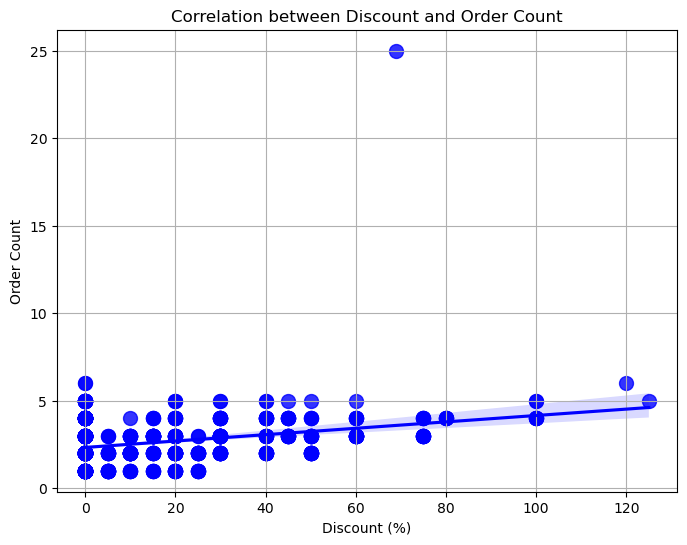

In [50]:
plt.figure(figsize=(8, 6))
sns.regplot(x='total_discount', y='order_count', data=df_6, color='blue', scatter_kws={'s': 100})
plt.xlabel('Discount (%)')
plt.ylabel('Order Count')
plt.title('Correlation between Discount and Order Count')
plt.grid(True)

# Show plot
plt.show()

In [55]:
sql7 = """
SELECT order_date AS order_date, 
	COUNT(order_id) AS order_count,
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit
FROM custom_table
GROUP BY 1
"""

In [56]:
df_7 = sqlio.read_sql_query(sql7, conn)
df_7.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/1868487040.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,order_date,order_count,profit
0,1996-09-09,4,1363.0
1,1997-10-28,2,550.0
2,1997-05-09,2,796.0
3,1997-08-20,4,3220.0
4,1998-05-04,5,2474.0


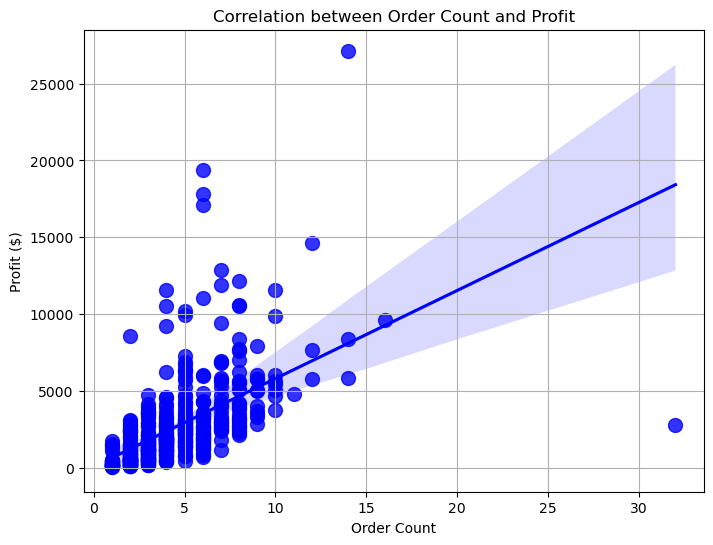

In [57]:
plt.figure(figsize=(8, 6))
sns.regplot(x='order_count', y='profit', data=df_7, color='blue', scatter_kws={'s': 100})
plt.xlabel('Order Count')
plt.ylabel('Profit ($)')
plt.title('Correlation between Order Count and Profit')
plt.grid(True)
plt.show()

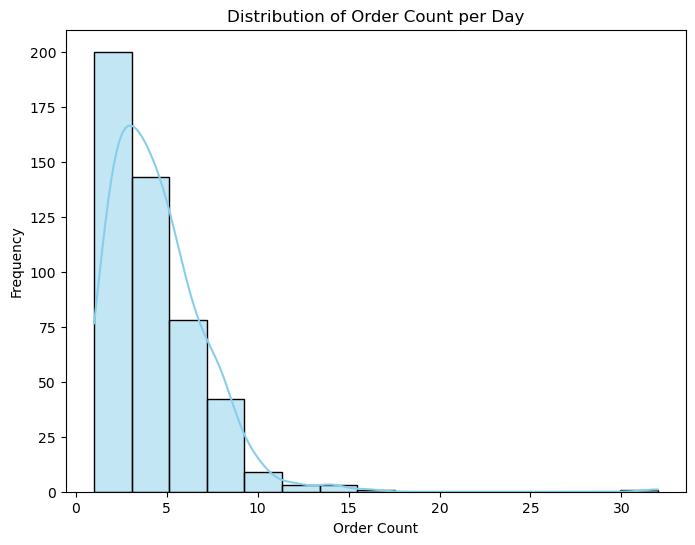

In [290]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_7, x='order_count', bins=15, kde=True, color='skyblue')
plt.xlabel('Order Count')
plt.ylabel('Frequency')
plt.title('Distribution of Order Count per Day')
plt.grid(False)
plt.show()

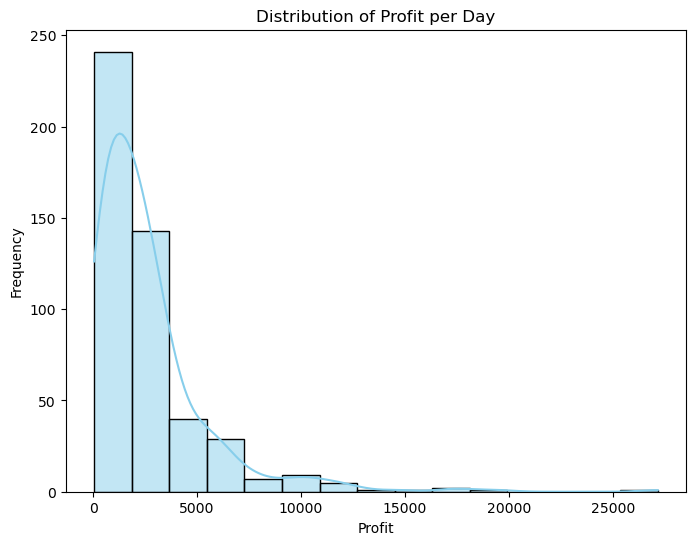

In [292]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_7, x='profit', bins=15, kde=True, color='skyblue')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Profit per Day')
plt.grid(False)
plt.show()

In [203]:
sql8 = """

SELECT product_name,
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit
FROM custom_table_2
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
"""

In [204]:
df_8 = sqlio.read_sql_query(sql8, conn)
df_8.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/965309210.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,product_name,profit
0,Côte de Blaye,141397.0
1,Thüringer Rostbratwurst,80369.0
2,Raclette Courdavault,71156.0
3,Tarte au sucre,47235.0
4,Camembert Pierrot,46825.0


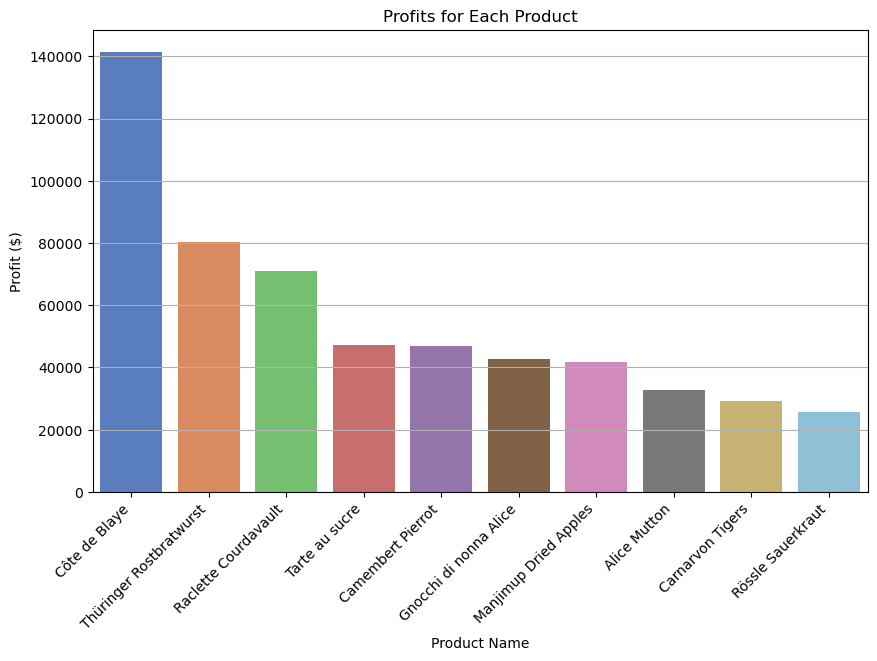

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_8, x='product_name', y='profit', palette='muted')
plt.xlabel('Product Name')
plt.ylabel('Profit ($)')
plt.title('Profits for Each Product')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [66]:
sql9 = """
SELECT category_name,
	ROUND(SUM(unit_price * quantity * (1 - discount))) AS profit
FROM custom_table_2
GROUP BY 1
"""

In [68]:
df_9 = sqlio.read_sql_query(sql9, conn)
df_9.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/2574106514.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,category_name,profit
0,Beverages,267868.0
1,Produce,99985.0
2,Condiments,106047.0
3,Grains/Cereals,95745.0
4,Meat/Poultry,163022.0


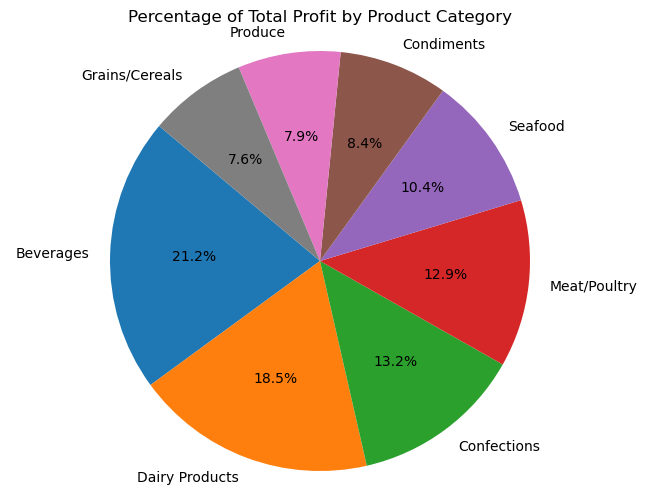

In [211]:
total_profit = df_9['profit'].sum()


df_9['profit_percentage'] = (df_9['profit'] / total_profit) * 100
df_9 = df_9.sort_values(by = 'profit_percentage', ascending = False)


plt.figure(figsize=(8, 6))
plt.pie(df_9['profit_percentage'], labels=df_9['category_name'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Profit by Product Category')
plt.axis('equal')
plt.show()

In [71]:
sql10 = """
SELECT *
FROM custom_table_2
"""

In [72]:
# Python Analysis
df_10 = sqlio.read_sql_query(sql10, conn) 
df_10.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3976306926.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,order_id,order_date,company_name,unit_price,quantity,discount,country,product_name,category_name
0,10248,1996-07-04,Vins et alcools Chevalier,14.0,12,0.0,France,Queso Cabrales,Dairy Products
1,10248,1996-07-04,Vins et alcools Chevalier,9.8,10,0.0,France,Singaporean Hokkien Fried Mee,Grains/Cereals
2,10248,1996-07-04,Vins et alcools Chevalier,34.8,5,0.0,France,Mozzarella di Giovanni,Dairy Products
3,10249,1996-07-05,Toms Spezialitäten,18.6,9,0.0,Germany,Tofu,Produce
4,10249,1996-07-05,Toms Spezialitäten,42.4,40,0.0,Germany,Manjimup Dried Apples,Produce


In [84]:
# group df_10 by prodcut name and count the total number of units sold
df_10.groupby(['product_name'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

,product_name,quantity
3,Camembert Pierrot,1577
51,Raclette Courdavault,1496
18,Gorgonzola Telino,1397
17,Gnocchi di nonna Alice,1263
46,Pavlova,1158
...,...,...
32,Laughing Lumberjack Lager,184
10,Chocolade,138
20,Gravad lax,125
16,Genen Shouyu,122


In [221]:
df_10['order_date'] = pd.to_datetime(df_10['order_date'])
sales_over_time = df_10.groupby(pd.Grouper(key='order_date', freq='M')).agg({'unit_price': 'sum', 'quantity': 'sum'}).reset_index()
sales_over_time

,order_date,unit_price,quantity
0,1996-07-31,1213.20,1462
1,1996-08-31,1487.50,1322
2,1996-09-30,1340.60,1124
3,1996-10-31,1604.90,1738
4,1996-11-30,1834.70,1735
5,1996-12-31,1929.30,2200
6,1997-01-31,2081.30,2401
7,1997-02-28,1507.70,2132
8,1997-03-31,1670.10,1770
9,1997-04-30,2260.13,1912


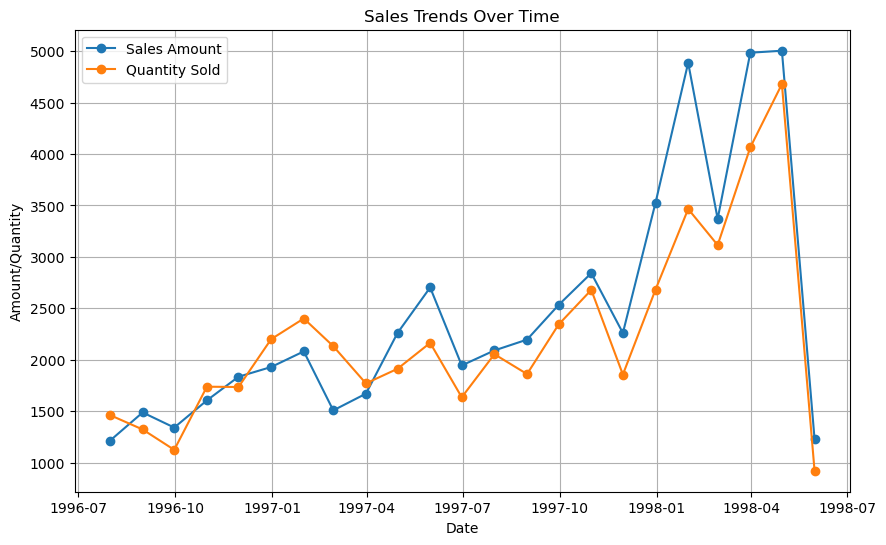

In [224]:
# Plot sales trends over time
plt.figure(figsize=(10, 6))
plt.plot(sales_over_time['order_date'], sales_over_time['unit_price'], marker='o', label='Sales Amount')
plt.plot(sales_over_time['order_date'], sales_over_time['quantity'], marker='o', label='Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Amount/Quantity')
plt.title('Sales Trends Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
# Distribution of customer profit
customer_profit = df_10.groupby('company_name')['profit'].sum().reset_index()
customer_profit.sort_values(by = 'profit', ascending = False)

,company_name,profit
59,QUICK-Stop,110277.3050
20,Ernst Handel,104874.9785
69,Save-a-lot Markets,104361.9500
63,Rattlesnake Canyon Grocery,51097.8005
36,Hungry Owl All-Night Grocers,49979.9050
...,...,...
29,Galería del gastrónomo,836.7000
52,North/South,649.0000
43,Laughing Bacchus Wine Cellars,522.5000
44,Lazy K Kountry Store,357.0000


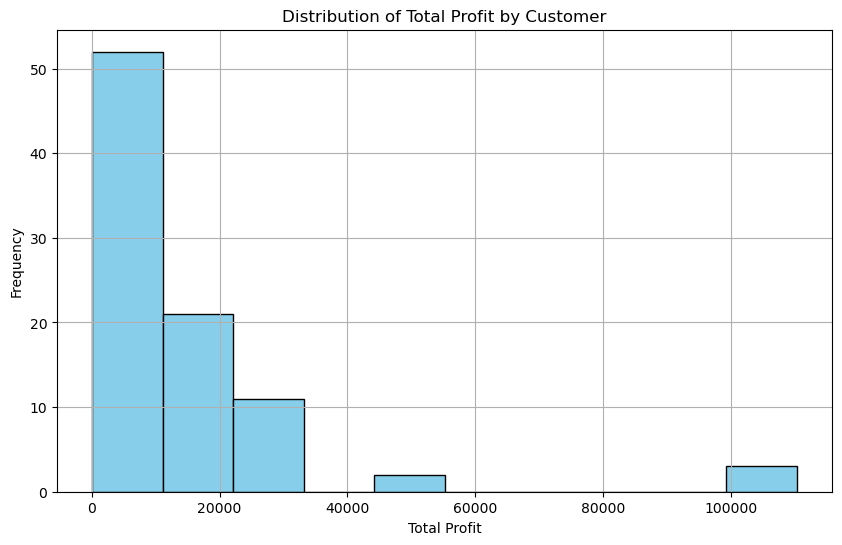

In [127]:
# Visualize distribution of total profit by customer
plt.figure(figsize=(10, 6))
plt.hist(customer_profit['profit'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Total Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Total Profit by Customer')
plt.grid(True)
plt.show()

In [254]:
average_customer_profit = customer_profit['profit'].mean()
top_customers = customer_profit[customer_profit['profit'] > average_customer_profit]

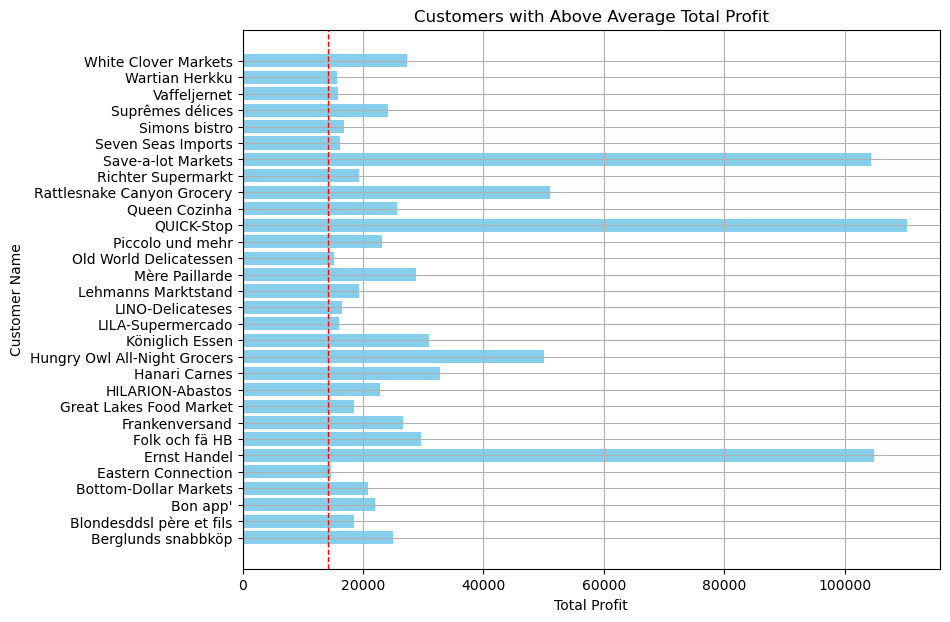

In [283]:
# Visualize remaining customers with their total profit
plt.figure(figsize=(9, 7))
plt.barh(top_customers['company_name'], top_customers['profit'], color='skyblue')
plt.axvline(x=average_customer_profit, color='red', linestyle='--', linewidth=1)
plt.xlabel('Total Profit')
plt.ylabel('Customer Name')
plt.title('Customers with Above Average Total Profit')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [274]:
# Countries by profit
df_10.groupby('country')['profit'].sum().reset_index().sort_values(by = 'profit', ascending = False)

,country,profit
19,USA,245584.6105
8,Germany,230284.6335
1,Austria,128003.8385
3,Brazil,106925.7765
7,France,81358.3225
18,UK,58971.3100
20,Venezuela,56810.6290
16,Sweden,54495.1400
4,Canada,50196.2900
9,Ireland,49979.9050


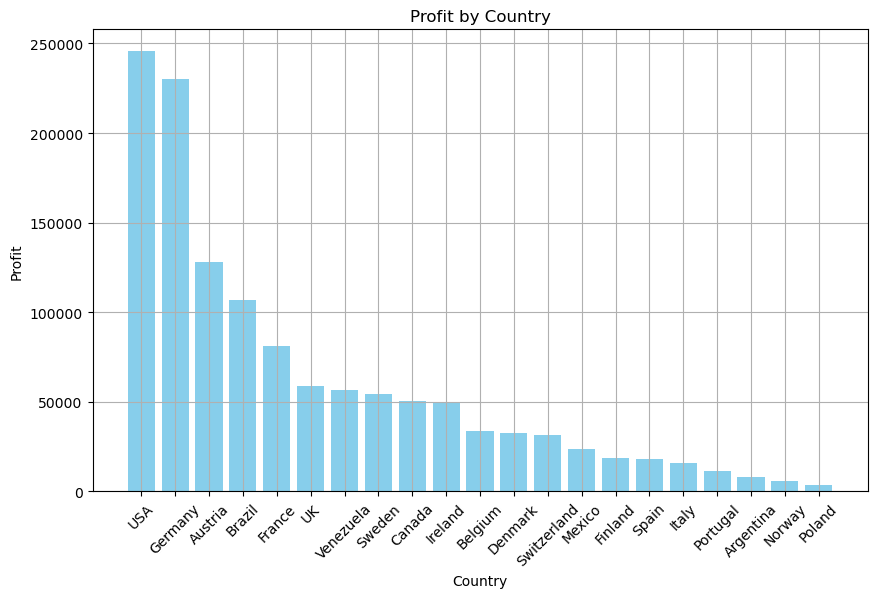

In [104]:
df_country = df_10.groupby('country')['profit'].sum().reset_index().sort_values(by = 'profit', ascending = False)

plt.figure(figsize=(10, 6))
plt.bar(df_country['country'], df_country['profit'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Profit')
plt.title('Profit by Country')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [128]:
sql11 = """
    WITH cte_2 AS (
	WITH cte AS (
	SELECT product_name, EXTRACT(YEAR FROM order_date) AS year,
	ROUND(AVG(quantity * unit_price * (1 - discount))) AS avg_profit
FROM custom_table_2
GROUP BY product_name, year
ORDER BY 1, 2
	)

SELECT *,
	LAG(avg_profit) OVER (PARTITION BY product_name ORDER BY year) AS previous_profit
FROM cte
WHERE year = 1998 OR year = 1997
	)
	
SELECT product_name, avg_profit, previous_profit, 
	ROUND(100*(avg_profit - previous_profit) / previous_profit) AS percentage_decrease
FROM cte_2
WHERE avg_profit < previous_profit
"""

In [129]:
df_11 = sqlio.read_sql_query(sql11, conn)
df_11.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3824511381.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,product_name,avg_profit,previous_profit,percentage_decrease
0,Alice Mutton,739.0,978.0,-24.0
1,Camembert Pierrot,910.0,976.0,-7.0
2,Carnarvon Tigers,850.0,1329.0,-36.0
3,Chang,350.0,391.0,-10.0
4,Chef Anton's Cajun Seasoning,300.0,521.0,-42.0


In [279]:
df_11 = df_11.sort_values(by = 'percentage_decrease', ascending = False)
df_11

,product_name,avg_profit,previous_profit,percentage_decrease
7,Geitost,48.0,49.0,-2.0
21,Pavlova,387.0,394.0,-2.0
33,Tunnbröd,222.0,229.0,-3.0
36,Zaanse koeken,186.0,195.0,-5.0
30,Spegesild,202.0,213.0,-5.0
1,Camembert Pierrot,910.0,976.0,-7.0
27,Singaporean Hokkien Fried Mee,310.0,338.0,-8.0
32,Tourtière,132.0,145.0,-9.0
3,Chang,350.0,391.0,-10.0
17,Northwoods Cranberry Sauce,765.0,852.0,-10.0


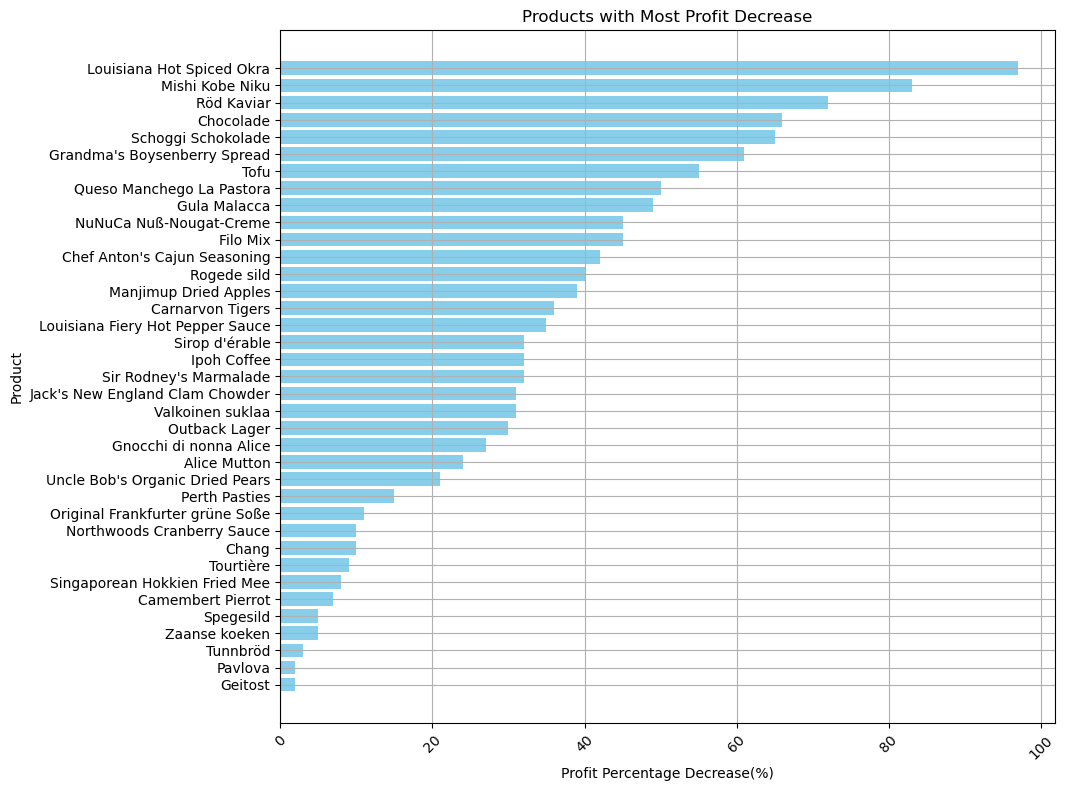

In [282]:
plt.figure(figsize=(10, 9))
plt.barh(df_11['product_name'], df_11['percentage_decrease'] * -1, color='skyblue')
plt.xlabel('Profit Percentage Decrease(%)')
plt.ylabel('Product')
plt.title('Products with Most Profit Decrease')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [143]:
sql12 = """
    SELECT country, COUNT(customer_id) AS country_count
FROM customers
GROUP BY country
ORDER BY 2 DESC;
"""

In [144]:
df_12 = sqlio.read_sql_query(sql12, conn)
df_12.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/1367533744.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,country,country_count
0,USA,13
1,Germany,11
2,France,11
3,Brazil,9
4,UK,7


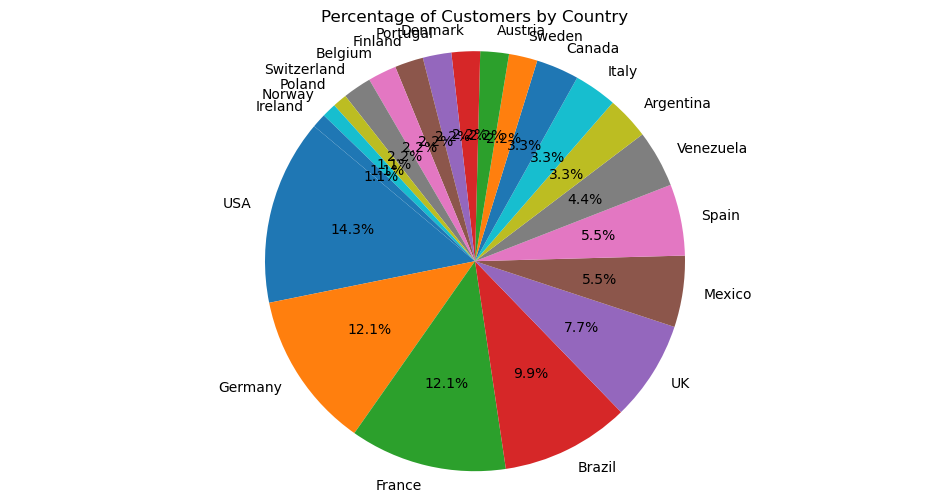

In [154]:
total_customer = df_12['country_count'].sum()


df_12['country_percentage'] = (df_12['country_count'] / total_customer) * 100


plt.figure(figsize=(12, 6))
plt.pie(df_12['country_percentage'], labels=df_12['country'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Customers by Country')
plt.axis('equal') 
plt.show()

In [155]:
sql13 = """
SELECT category_name,
	COUNT(product_name) AS product_count
FROM products
LEFT JOIN categories
ON products.category_id = categories.category_id
GROUP BY category_name
ORDER BY 2 DESC;
"""

In [157]:
df_13 = sqlio.read_sql_query(sql13, conn)
df_13.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3715112289.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,category_name,product_count
0,Confections,13
1,Condiments,12
2,Beverages,12
3,Seafood,12
4,Dairy Products,10


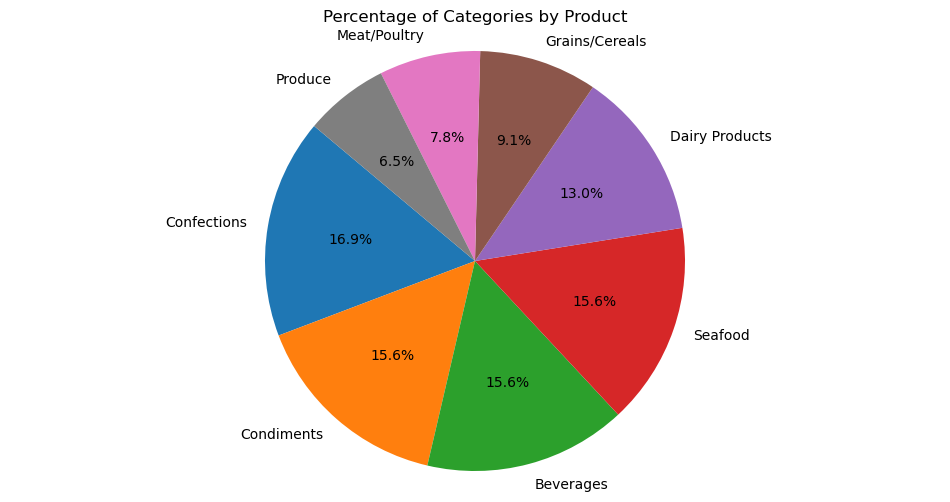

In [158]:
total_product = df_13['product_count'].sum()


df_13['category_percentage'] = (df_13['product_count'] / total_product) * 100


plt.figure(figsize=(12, 6))
plt.pie(df_13['category_percentage'], labels=df_13['category_name'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Categories by Product')
plt.axis('equal') 
plt.show()

In [159]:
sql14 = """
SELECT products.product_name, ROUND(SUM(order_details.unit_price * order_details.quantity * (1 - discount))) AS product_sale
FROM orders
LEFT JOIN order_details
ON orders.order_id = order_details.order_id
LEFT JOIN products
ON order_details.product_id = products.product_id
WHERE EXTRACT(YEAR FROM order_date) = 1998
GROUP BY 1 
ORDER BY product_sale DESC
LIMIT 10;
"""

In [160]:
df_14 = sqlio.read_sql_query(sql14, conn)
df_14.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/1617950435.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,product_name,product_sale
0,Côte de Blaye,67324.0
1,Thüringer Rostbratwurst,33683.0
2,Raclette Courdavault,26345.0
3,Camembert Pierrot,17295.0
4,Tarte au sucre,15993.0


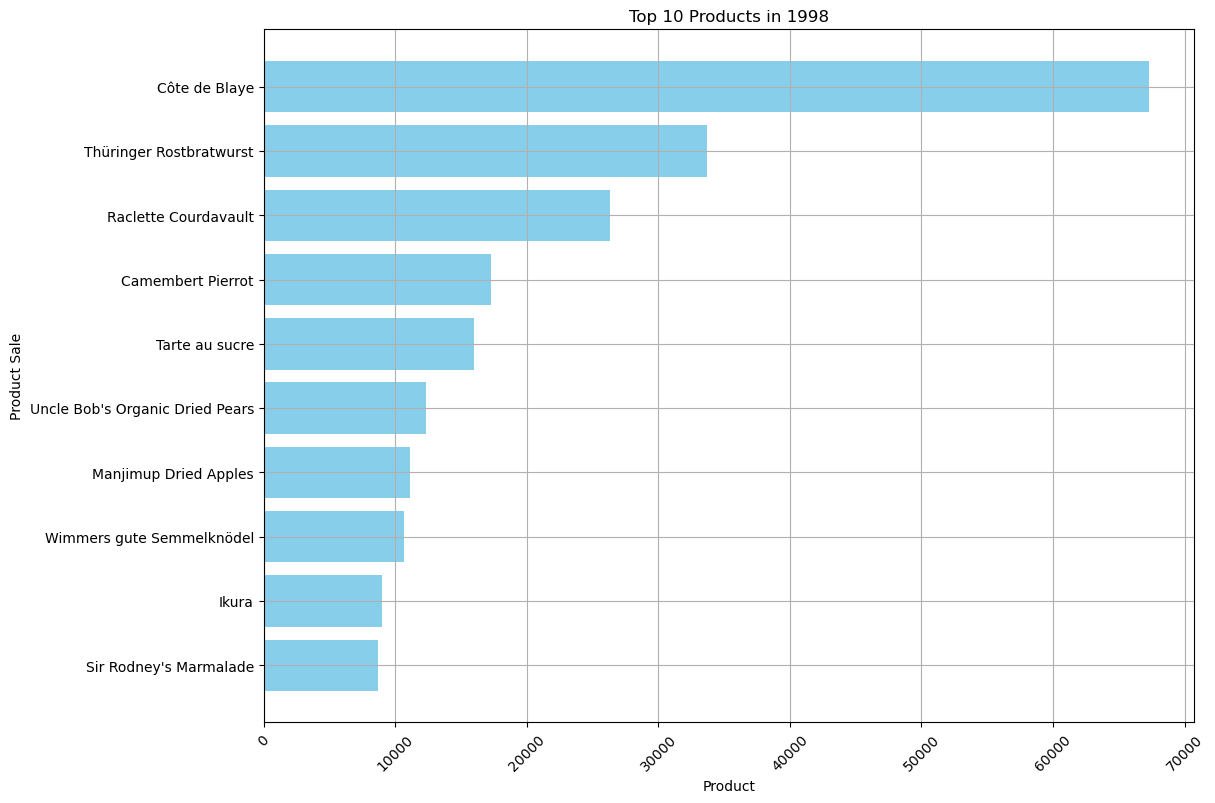

In [166]:
df_14 = df_14.sort_values(by='product_sale', ascending=True)

plt.figure(figsize=(12, 9))
plt.barh(df_14['product_name'], df_14['product_sale'], color='skyblue')
plt.xlabel('Product')
plt.ylabel('Product Sale')
plt.title('Top 10 Products in 1998')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [168]:
sql15 = """
SELECT products.product_name,
	SUM(order_details.quantity) AS product_order_count
FROM orders
LEFT JOIN order_details
ON orders.order_id = order_details.order_id
LEFT JOIN products
ON order_details.product_id = products.product_id
WHERE EXTRACT(YEAR FROM order_date) = 1998
GROUP BY 1
ORDER BY product_order_count DESC
LIMIT 10;
"""

In [169]:
df_15 = sqlio.read_sql_query(sql15, conn)
df_15.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/3761059887.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,product_name,product_order_count
0,Konbu,659
1,Guaraná Fantástica,546
2,Camembert Pierrot,542
3,Raclette Courdavault,513
4,Uncle Bob's Organic Dried Pears,414


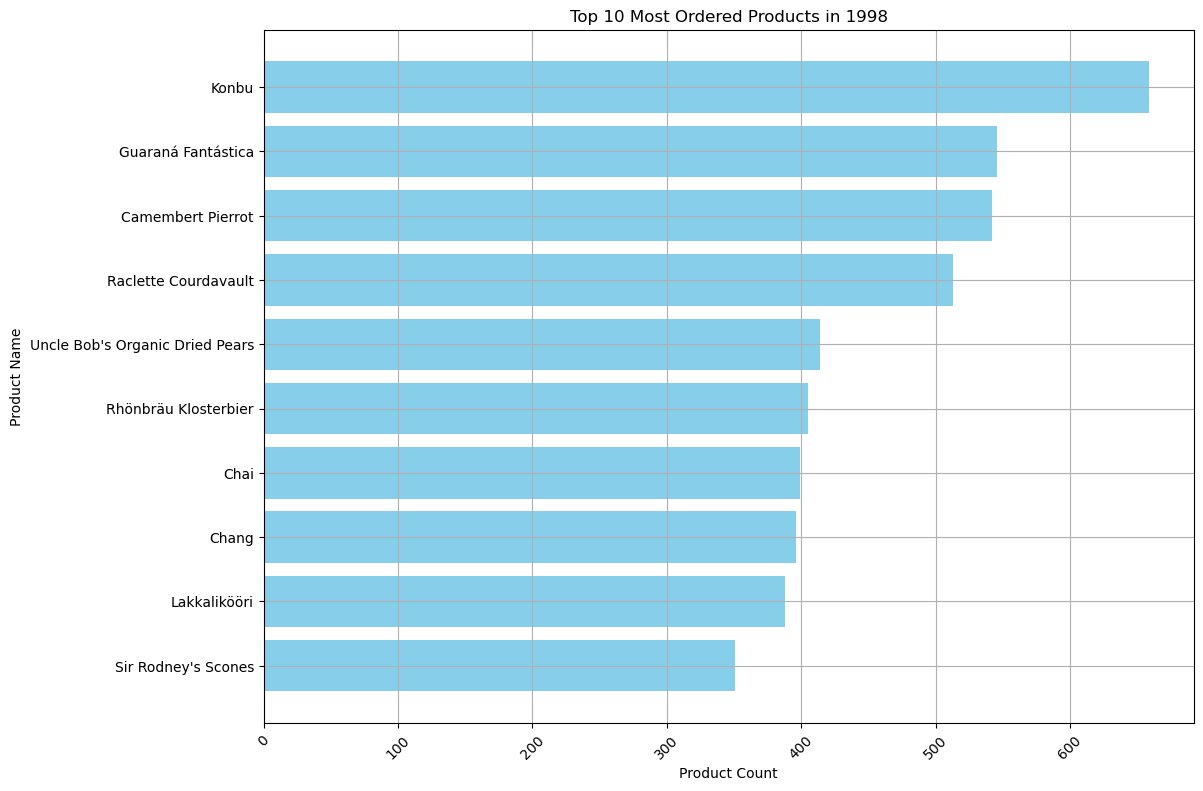

In [182]:
df_15 = df_15.sort_values(by='product_order_count', ascending=True)

plt.figure(figsize=(12, 9))
plt.barh(df_15['product_name'], df_15['product_order_count'], color='skyblue')
plt.xlabel('Product Count')
plt.ylabel('Product Name')
plt.title('Top 10 Most Ordered Products in 1998')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [285]:
sql16 = """
    WITH cte AS (
	SELECT DATE_TRUNC('month', order_date)::date AS year_month,
	SUM(profit) AS total_profit
FROM order_profit
GROUP BY 1
ORDER BY 1 ASC
	)

SELECT *,
	LAG(total_profit) OVER (ORDER BY year_month) AS previous_profit,
	100 * (ROUND((total_profit / LAG(total_profit) OVER (ORDER BY year_month))::numeric, 2) - 1) AS profit_change
FROM cte
WHERE year_month BETWEEN '1997-04-01' AND '1998-05-01'
"""

In [286]:
df_16 = sqlio.read_sql_query(sql16, conn)
df_16 = df_16.iloc[1:]
df_16.head()

/var/folders/3y/_1t6dn8958q6h6nn5jfj_s1h0000gn/T/ipykernel_41182/2910167675.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,year_month,total_profit,previous_profit,profit_change
1,1997-05-01,53777.0,53033.0,1.0
2,1997-06-01,36365.0,53777.0,-32.0
3,1997-07-01,51020.0,36365.0,40.0
4,1997-08-01,47287.0,51020.0,-7.0
5,1997-09-01,55626.0,47287.0,18.0


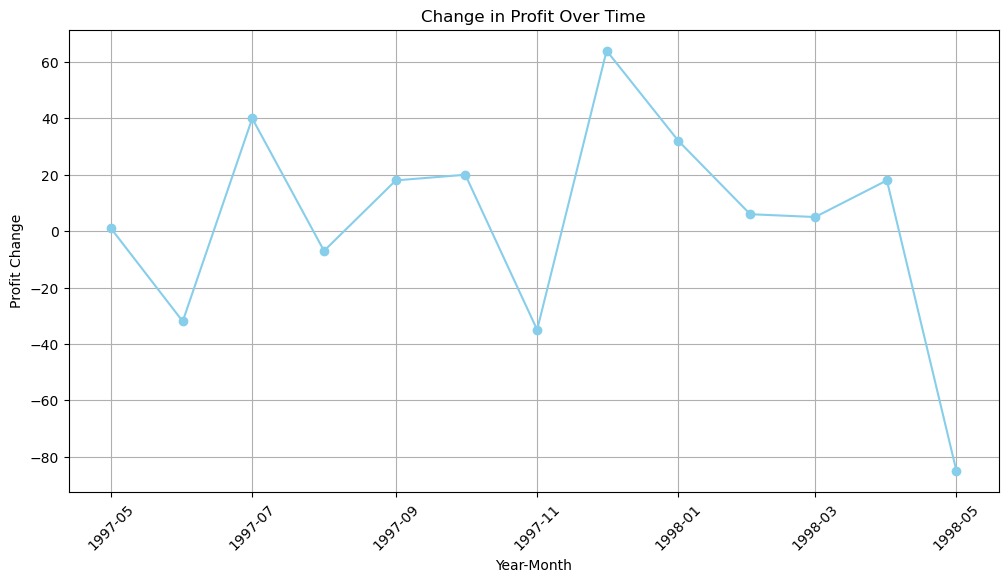

In [287]:
df_16['year_month'] = pd.to_datetime(df_16['year_month'])

plt.figure(figsize=(12, 6))
plt.plot(df_16['year_month'], df_16['profit_change'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Profit Change')
plt.title('Change in Profit Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()